<a id="1"></a> <br>
## Step 1 : Data Understanding

In [2]:
# Importar as libs necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

In [4]:
# Importar o dataset

retail = pd.read_csv('ecommerce.csv', sep=";",encoding="ISO-8859-1", header=0)
retail.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0
1,536365,WHITE METAL LANTERN,06/06/2021 08:26,6,3.39,17850.0
2,536365,CREAM CUPID HEARTS COAT HANGER,06/06/2021 08:26,8,2.75,17850.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,06/06/2021 08:26,6,3.39,17850.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,06/06/2021 08:26,6,3.39,17850.0


In [5]:
# shape do df

retail.shape

(541838, 6)

In [6]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541838 entries, 0 to 541837
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_pedido       541838 non-null  object 
 1   descricao       540384 non-null  object 
 2   data_pgto       541838 non-null  object 
 3   quantidade      541838 non-null  int64  
 4   preco_unitario  541838 non-null  float64
 5   id_cliente      406829 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 24.8+ MB


In [7]:
# df descrição

retail.describe()

,quantidade,preco_unitario,id_cliente
count,541838.000000,541838.000000,406829.000000
mean,9.112284,4.611655,15287.690570
std,16.679916,96.766177,1713.600303
min,1.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,12.000000,4.130000,16791.000000
max,153.000000,38970.000000,18287.000000


<a id="2"></a> <br>
## Step 2 : Data Cleaning

In [8]:
# Calcular % de nulos

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

id_pedido          0.00
descricao          0.27
data_pgto          0.00
quantidade         0.00
preco_unitario     0.00
id_cliente        24.92
dtype: float64

In [9]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 6)

In [10]:
retail.describe()

,quantidade,preco_unitario,id_cliente
count,406829.000000,406829.000000,406829.000000
mean,10.915343,3.460471,15287.690570
std,18.040345,69.315162,1713.600303
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,152.000000,38970.000000,18287.000000


In [11]:
# Transformar id_cliente em string

retail['id_cliente'] = retail['id_cliente'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [ ]:
retail.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0
1,536365,WHITE METAL LANTERN,06/06/2021 08:26,6,3.39,17850.0
2,536365,CREAM CUPID HEARTS COAT HANGER,06/06/2021 08:26,8,2.75,17850.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,06/06/2021 08:26,6,3.39,17850.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,06/06/2021 08:26,6,3.39,17850.0


In [12]:
# Novo atributo : Ticket Médio
rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum})
rfm_m.dtypes

preco_unitario    float64
dtype: object

In [13]:
rfm_m.head()

,preco_unitario
id_cliente,
12346.0,2.08
12347.0,481.21
12348.0,178.71
12349.0,605.10
12350.0,65.30


In [14]:
# Novo atributo : Ticket Médio
#rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum,"id_pedido": lambda x : x.nunique()})
#rfm_m['id_pedido'] = rfm_m['id_pedido'].astype(float)
#rfm_m['ticket_medio'] = rfm_m['preco_unitario']/rfm_m['id_pedido']
rfm_m = retail.groupby(['id_cliente']).agg({"preco_unitario": np.sum})
rfm_m = rfm_m.reset_index()
rfm_m = rfm_m[['id_cliente', 'preco_unitario']]
rfm_m.head()

,id_cliente,preco_unitario
0,12346.0,2.08
1,12347.0,481.21
2,12348.0,178.71
3,12349.0,605.10
4,12350.0,65.30


In [15]:
# Novo atributo : Frequência

rfm_f = retail.groupby('id_cliente')['id_pedido'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['id_cliente', 'frequencia']
rfm_f.head()

,id_cliente,frequencia
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [16]:
# Unindo os 2 datasets

rfm = pd.merge(rfm_m, rfm_f, on='id_cliente', how='inner')
rfm.head()

,id_cliente,preco_unitario,frequencia
0,12346.0,2.08,2
1,12347.0,481.21,182
2,12348.0,178.71,31
3,12349.0,605.10,73
4,12350.0,65.30,17


In [17]:
# Novo atributo : Recência

# Convert to datetime to proper datatype

retail['data_pgto'] = pd.to_datetime(retail['data_pgto'])

In [18]:
# Compute the maximum date to know the last transaction date

today = pd.Timestamp.today()  

In [19]:
retail = retail[retail.data_pgto<=today]

In [20]:
retail.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0
1,536365,WHITE METAL LANTERN,2021-06-06 08:26:00,6,3.39,17850.0
2,536365,CREAM CUPID HEARTS COAT HANGER,2021-06-06 08:26:00,8,2.75,17850.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2021-06-06 08:26:00,6,3.39,17850.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2021-06-06 08:26:00,6,3.39,17850.0


In [21]:
# Compute the difference between max date and transaction date

retail['Diff'] = today - retail['data_pgto']
retail.head()

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,Diff
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2021-06-06 08:26:00,6,2.55,17850.0,390 days 15:49:50.118736
1,536365,WHITE METAL LANTERN,2021-06-06 08:26:00,6,3.39,17850.0,390 days 15:49:50.118736
2,536365,CREAM CUPID HEARTS COAT HANGER,2021-06-06 08:26:00,8,2.75,17850.0,390 days 15:49:50.118736
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2021-06-06 08:26:00,6,3.39,17850.0,390 days 15:49:50.118736
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2021-06-06 08:26:00,6,3.39,17850.0,390 days 15:49:50.118736


In [22]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('id_cliente')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,id_cliente,Diff
0,12346.0,342 days 13:58:50.118736
1,12347.0,26 days 11:50:50.118736
2,12348.0,92 days 11:02:50.118736
3,12349.0,35 days 14:24:50.118736
4,12350.0,327 days 08:14:50.118736


In [23]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,id_cliente,Diff
0,12346.0,342
1,12347.0,26
2,12348.0,92
3,12349.0,35
4,12350.0,327


In [24]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='id_cliente', how='inner')
rfm.columns = ['id_cliente', 'ticket_medio', 'frequencia', 'recencia']
rfm.head()

,id_cliente,ticket_medio,frequencia,recencia
0,12346.0,2.08,2,342
1,12347.0,481.21,182,26
2,12348.0,178.71,31,92
3,12349.0,605.10,73,35
4,12350.0,65.30,17,327


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

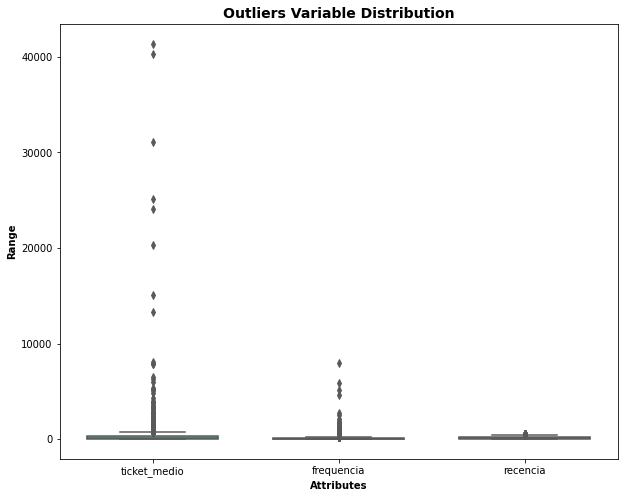

In [25]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['ticket_medio','frequencia','recencia']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [26]:
#Retirando 5% de outlier
rfm=rfm[rfm['ticket_medio'] < rfm['ticket_medio'].quantile(.95)]
rfm=rfm[rfm['frequencia'] < rfm['frequencia'].quantile(.95)]
rfm=rfm[rfm['recencia'] < rfm['recencia'].quantile(.95)]

Text(0.5, 0, 'Attributes')

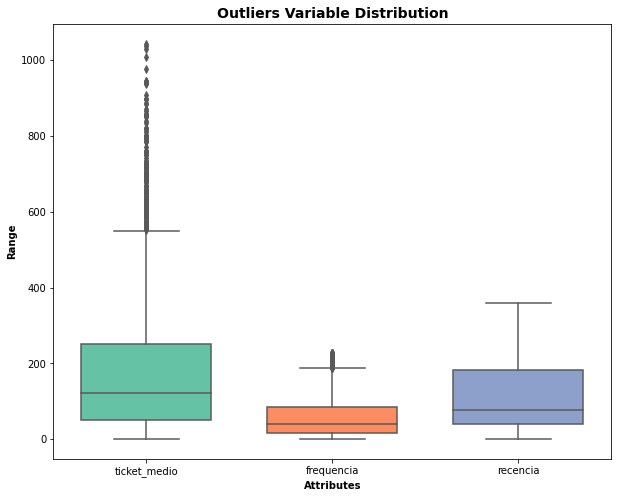

In [27]:
attributes = ['ticket_medio','frequencia','recencia']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [28]:
rfm.describe()

,ticket_medio,frequencia,recencia
count,3576.000000,3576.000000,3576.000000
mean,179.150832,57.590604,117.990213
std,173.263978,52.826272,93.496567
min,0.000000,1.000000,0.000000
25%,51.117500,17.000000,41.000000
50%,122.490000,39.000000,78.000000
75%,250.885000,85.000000,182.000000
max,1043.220000,228.000000,358.000000


### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

rfm_df = rfm[['ticket_medio', 'frequencia','recencia']]

scaler = MinMaxScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)

In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.describe()

,0,1,2
count,3561.000000,3561.000000,3561.000000
mean,0.177534,0.251952,0.335144
std,0.171883,0.233683,0.259976
min,0.000000,0.000000,0.000000
25%,0.050965,0.073733,0.117318
50%,0.121172,0.170507,0.240223
75%,0.248599,0.377880,0.519553
max,1.000000,1.000000,1.000000


In [29]:
# Rescaling the attributes

rfm_df = rfm[['ticket_medio', 'frequencia','recencia']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3576, 3)

In [30]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.describe()

,0,1,2
count,3.576000e+03,3.576000e+03,3.576000e+03
mean,-7.947905e-17,-4.371348e-17,1.241860e-17
std,1.000140e+00,1.000140e+00,1.000140e+00
min,-1.034121e+00,-1.071409e+00,-1.262150e+00
25%,-7.390529e-01,-7.684866e-01,-8.235701e-01
50%,-3.270660e-01,-3.519689e-01,-4.277783e-01
75%,4.140745e-01,5.189317e-01,6.847175e-01
max,4.987707e+00,3.226297e+00,2.567403e+00


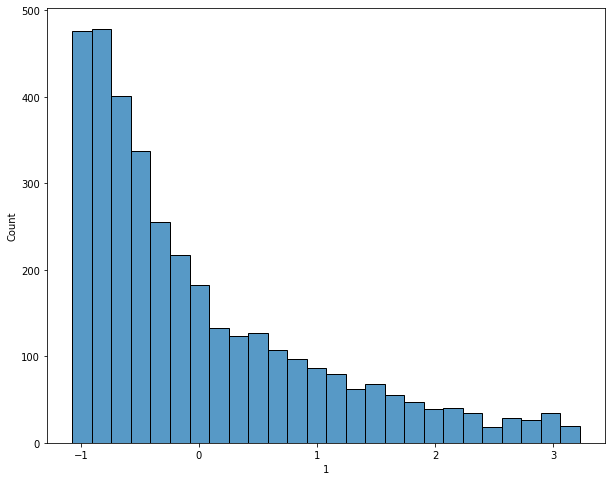

In [31]:
sns.histplot(x=1, data=rfm_df_scaled)

<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

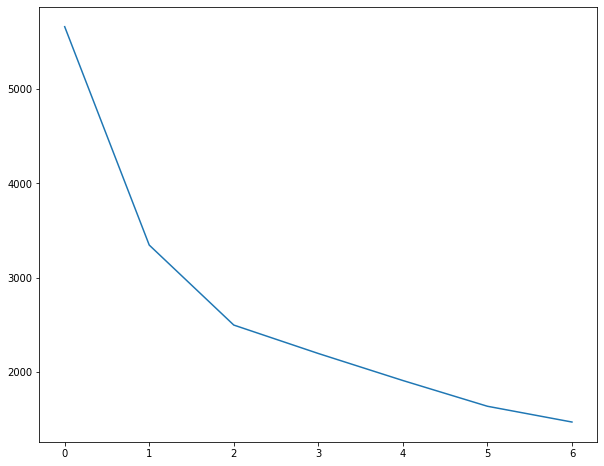

In [32]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.3778281596069096
For n_clusters=3, the silhouette score is 0.4369892694368534
For n_clusters=4, the silhouette score is 0.38645024882199175
For n_clusters=5, the silhouette score is 0.35175868906967134
For n_clusters=6, the silhouette score is 0.3596102589485721
For n_clusters=7, the silhouette score is 0.3458240705683411
For n_clusters=8, the silhouette score is 0.35451262234875747


In [67]:
# Final model with k=3
kmeans = KMeans(n_clusters=2, max_iter=10)
kmeans.labels_= kmeans.fit_predict(rfm_df_scaled)
df_kmeans=rfm

In [68]:
 kmeans.labels_

array([1, 0, 1, ..., 1, 1, 1], dtype=int32)

In [69]:
# assign the label
df_kmeans['Cluster_Id'] = kmeans.labels_.astype('str')
df_kmeans.head()


,id_cliente,ticket_medio,frequencia,recencia,Cluster_Id,Cluster_Labels,labels_dbscan
0,12346.0,2.08,2,342,1,0,0
1,12347.0,481.21,182,26,0,1,0
2,12348.0,178.71,31,92,1,0,0
3,12349.0,605.10,73,35,0,1,-1
4,12350.0,65.30,17,327,1,0,0


,recencia,frequencia,labels
0,-2.269768,1.653412,1
1,3.058303,0.171392,0
2,-0.227830,-0.372394,1
3,2.123104,0.010483,0
4,-1.784909,1.683501,1


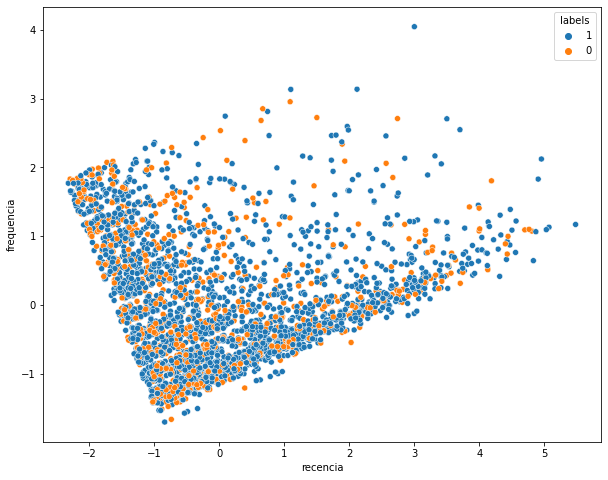

In [70]:
# PCA não se adequa a essa base de dados
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pc=pca.fit_transform(rfm_df_scaled)

pdf=pd.DataFrame(data=pc,columns=['recencia','frequencia'])
pdf['labels']=df_kmeans['Cluster_Id']
sns.scatterplot(data=pdf,x='recencia',y='frequencia',hue='labels')
pdf.head()

In [61]:
rfm.groupby('Cluster_Id').count()

,id_cliente,ticket_medio,frequencia,recencia,Cluster_Labels,labels_dbscan
Cluster_Id,,,,,,
0,964,964,964,964,964,964
1,787,787,787,787,787,787
2,1825,1825,1825,1825,1825,1825


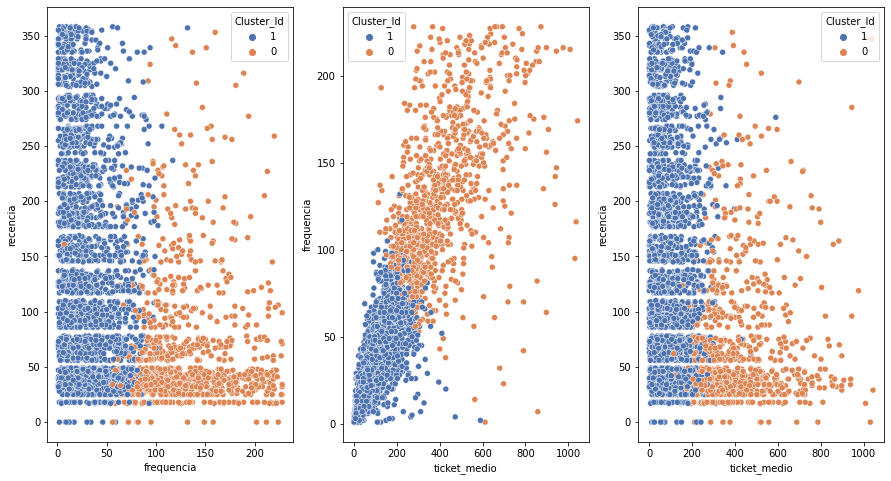

In [71]:
#Plota comparação entre as variáveis para análise do Cluster

f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=rfm,x='frequencia',y='recencia',hue='Cluster_Id',ax=axes[0],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='frequencia',hue='Cluster_Id',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='recencia',hue='Cluster_Id',ax=axes[2],palette="deep")


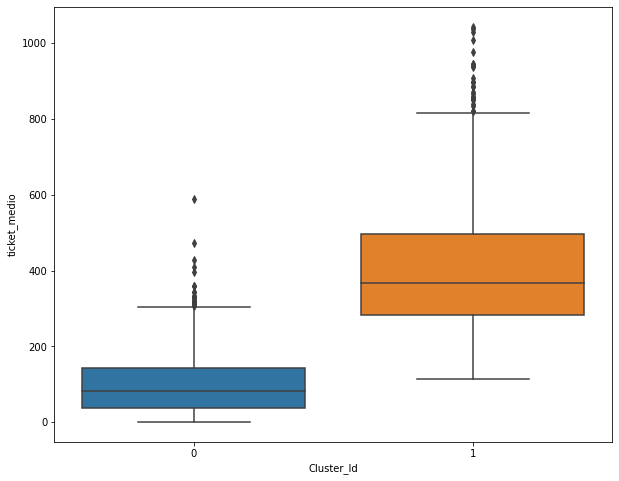

In [40]:
# Box plot para visualizar Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='ticket_medio', data=rfm)

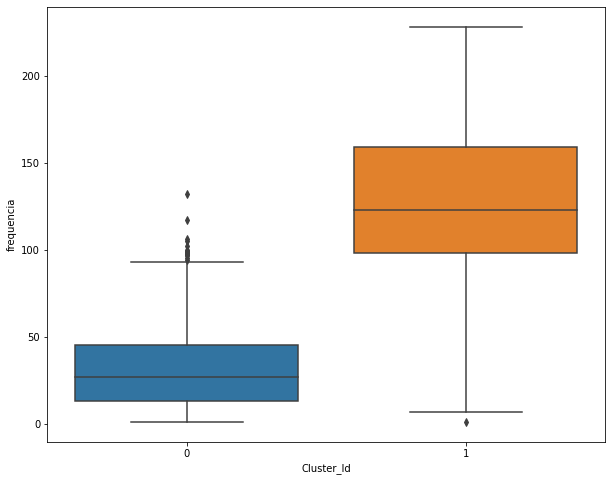

In [41]:
# Box plot para visualizar Cluster Id vs Frequencia

sns.boxplot(x='Cluster_Id', y='frequencia', data=rfm)

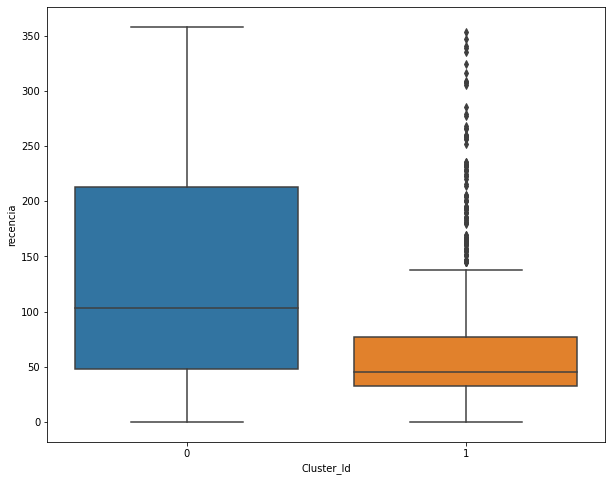

In [42]:
# Box plot para visualizar Cluster Id vs Recência

sns.boxplot(x='Cluster_Id', y='recencia', data=rfm)

### Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, 
- Divisive 
- Agglomerative.

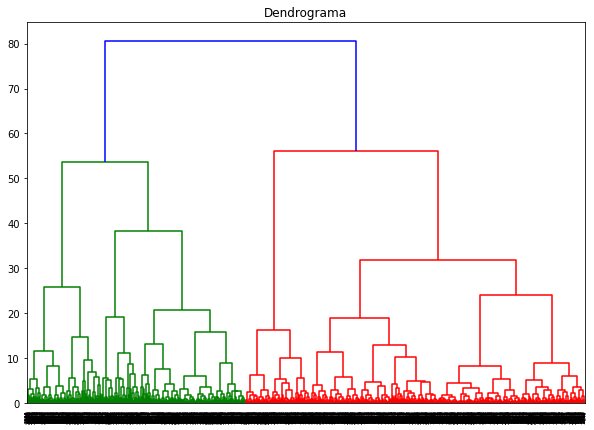

In [ ]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograma")  
dend = shc.dendrogram(shc.linkage(rfm_df_scaled, method='ward'))
#plt.axhline(y=20, color='r', linestyle='--')

#### Cutting the Dendrogram based on K

In [72]:
cluster = AgglomerativeClustering(n_clusters=2)  
cluster_labels = cluster.fit_predict(rfm_df_scaled)
rfm['Cluster_Labels'] = cluster_labels
hierarq = rfm
rfm.head()

,id_cliente,ticket_medio,frequencia,recencia,Cluster_Id,Cluster_Labels,labels_dbscan
0,12346.0,2.08,2,342,1,0,0
1,12347.0,481.21,182,26,0,1,0
2,12348.0,178.71,31,92,1,0,0
3,12349.0,605.10,73,35,0,1,-1
4,12350.0,65.30,17,327,1,0,0


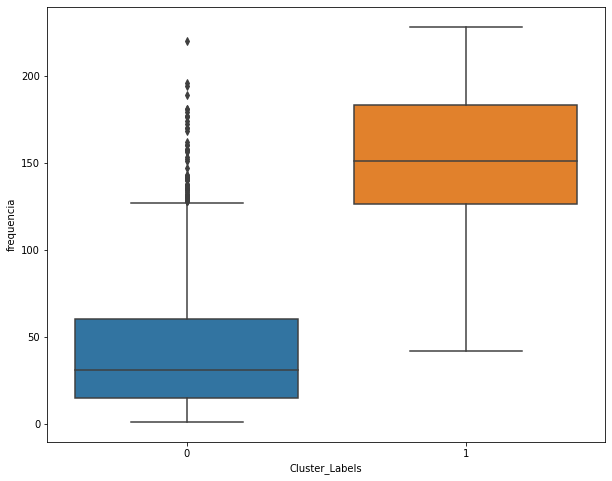

In [44]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='frequencia', data=rfm)

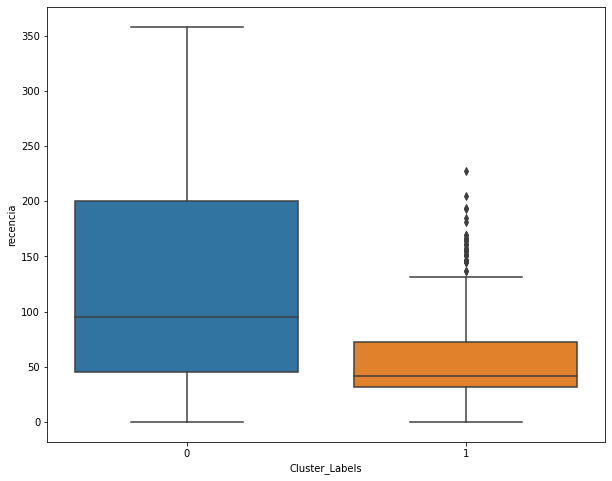

In [45]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='recencia', data=rfm)

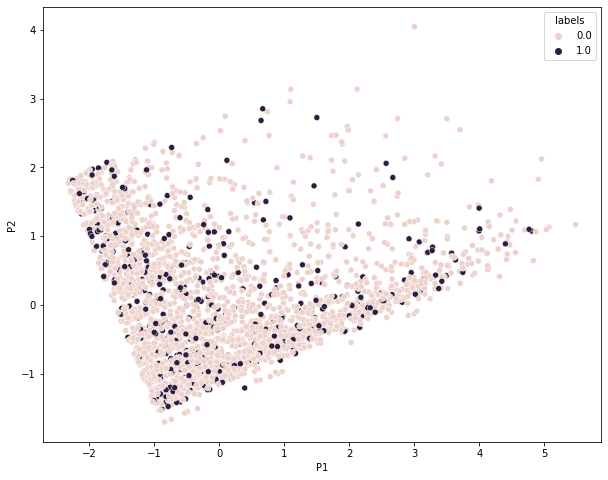

In [46]:
#para visualizar melhor essa distribuição, podemos cruzar algumas variáveis e ver como fica a clusterização
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(rfm_df_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['P1', 'P2'])
principalDf['labels']=rfm['Cluster_Labels']
sns.scatterplot(data=principalDf,x='P1',y='P2',hue='labels')

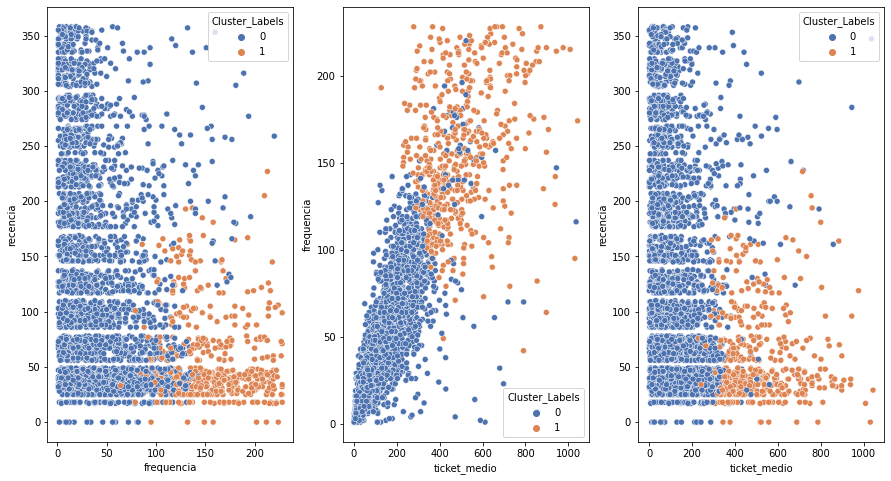

In [73]:
#Plota comparação entre as variáveis para análise do Cluster

f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=rfm,x='frequencia',y='recencia',hue='Cluster_Labels',ax=axes[0],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='frequencia',hue='Cluster_Labels',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='ticket_medio',y='recencia',hue='Cluster_Labels',ax=axes[2],palette="deep")

### DBScan

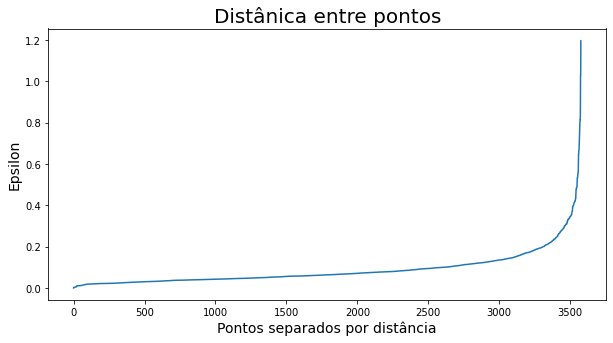

In [48]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(rfm_df_scaled)
distances, indices = nbrs.kneighbors(rfm_df_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('Distânica entre pontos',fontsize=20)
plt.xlabel('Pontos separados por distância',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [51]:
db = DBSCAN(eps=0.4, min_samples=10).fit(rfm_df_scaled)
labels_dbscan = db.labels_
df_dbscan=rfm
df_dbscan['labels_dbscan']=labels_dbscan.astype('str')

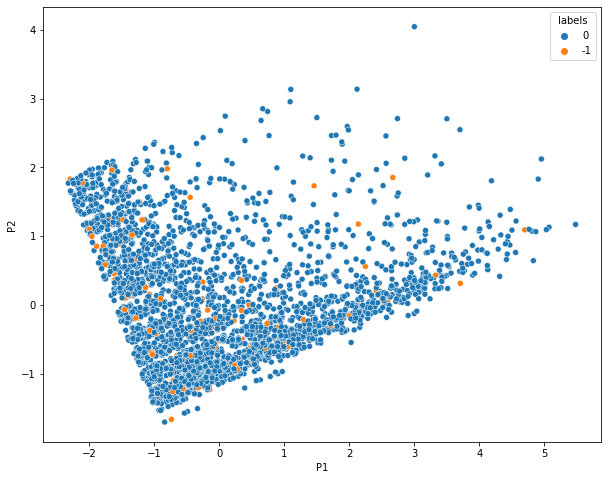

In [52]:
#Ele não consegue criar clusters
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(rfm_df_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['P1', 'P2'])
principalDf['labels']=df_dbscan['labels_dbscan']
sns.scatterplot(data=principalDf,x='P1',y='P2',hue='labels')

## Comparativa entre resultados

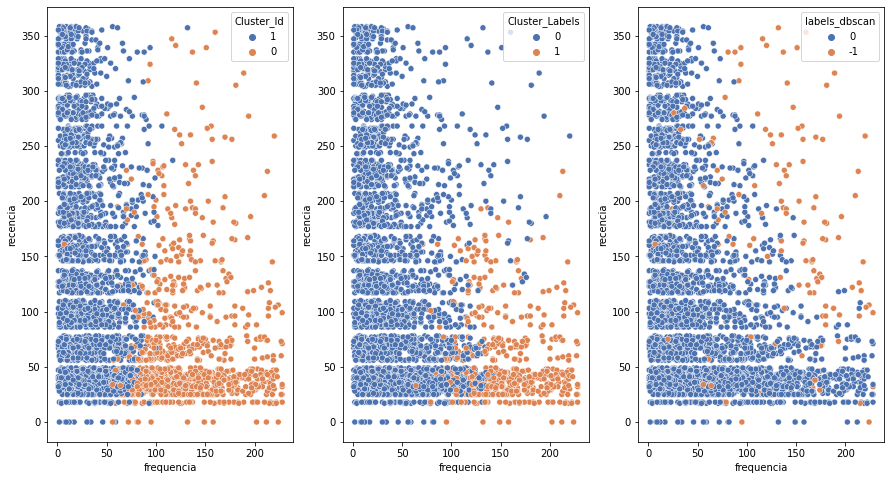

In [74]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=df_kmeans,x='frequencia',y='recencia',hue='Cluster_Id',ax=axes[0],palette="deep")
sns.scatterplot(data=hierarq,x='frequencia',y='recencia',hue='Cluster_Labels',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='frequencia',y='recencia',hue='labels_dbscan',ax=axes[2],palette="deep")

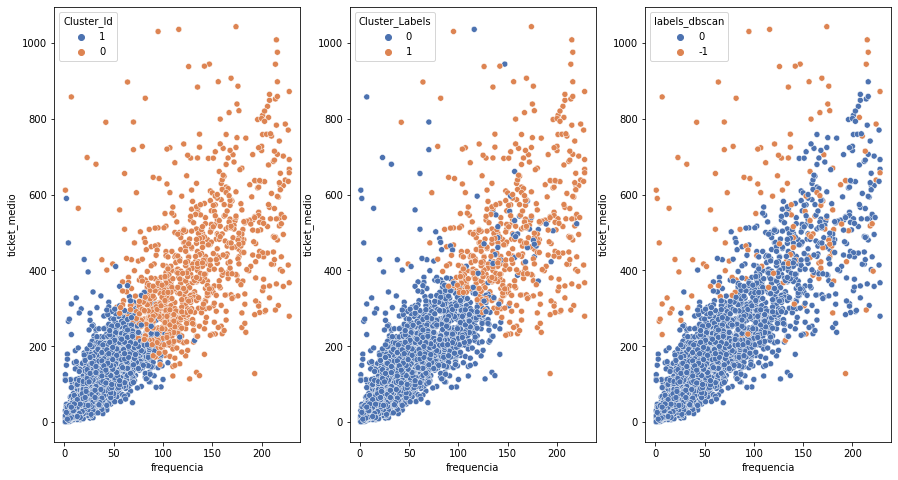

In [75]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(15, 8))
sns.scatterplot(data=df_kmeans,x='frequencia',y='ticket_medio',hue='Cluster_Id',ax=axes[0],palette="deep")
sns.scatterplot(data=hierarq,x='frequencia',y='ticket_medio',hue='Cluster_Labels',ax=axes[1],palette="deep")
sns.scatterplot(data=rfm,x='frequencia',y='ticket_medio',hue='labels_dbscan',ax=axes[2],palette="deep")

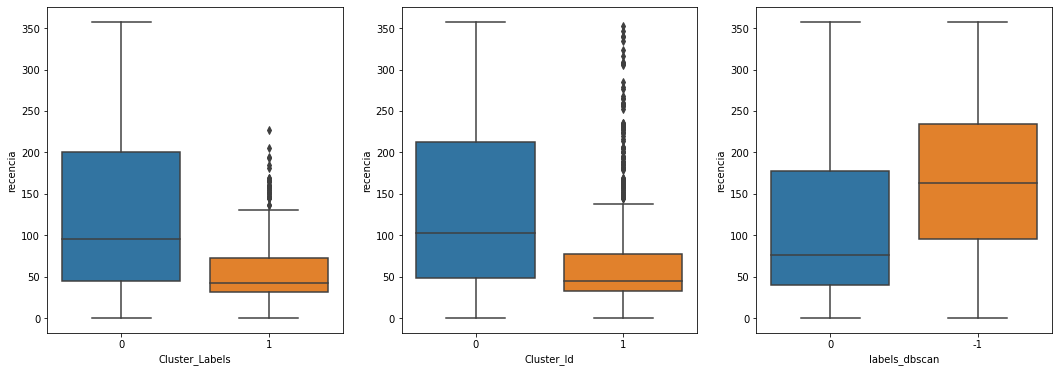

In [54]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(18, 6))
sns.boxplot(x='Cluster_Labels', y='recencia', data=rfm,ax=axes[0])
sns.boxplot(x='Cluster_Id', y='recencia', data=rfm,ax=axes[1])
sns.boxplot(x='labels_dbscan', y='recencia', data=rfm,ax=axes[2])

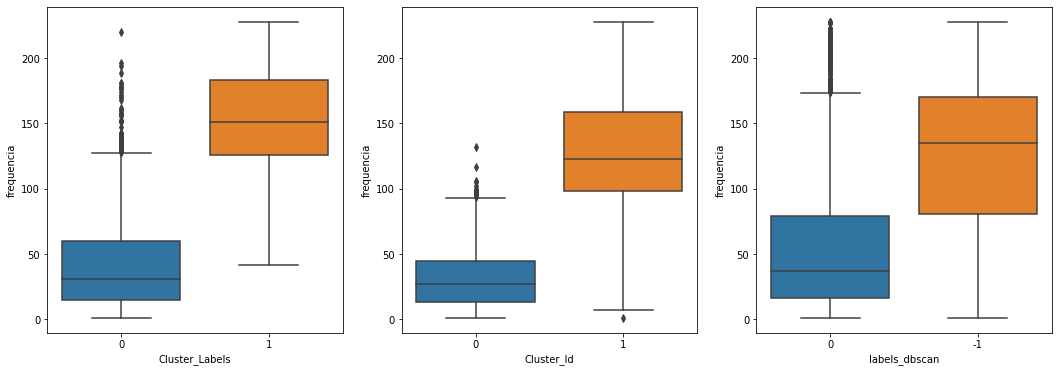

In [55]:
# Plot Cluster Id vs Amount
f, axes = plt.subplots(1, 3,figsize=(18, 6))
sns.boxplot(x='Cluster_Labels', y='frequencia', data=rfm,ax=axes[0])
sns.boxplot(x='Cluster_Id', y='frequencia', data=rfm,ax=axes[1])
sns.boxplot(x='labels_dbscan', y='frequencia', data=rfm,ax=axes[2])

<a id="5"></a> <br>
## Step 5 : Final Analysis

Kmeans com 2 clusters
- Cliente no Cluster 1 tem alta frequência e uma baixa recência e um alto ticket, significando que ele compra bastante e atualmente consome. Sugestão: Promoções e pontos para ele seguir cliente.
- Clientes do cluster 0 já possuem um ticket menor e uma boa parte possui recencia alta e pouca frequencia. Uma sugestão seria fidelizar esse cliente através de promoções.

Algoritmo bom para escalar, caso o cliente deseje manter esse modelo.

Cluster Hierárquico com 2 clusters
- Cliente no Cluster 1 tem alta frequência e uma baixa recência e um alto ticket, significando que ele compra bastante e atualmente consome. Sugestão: Promoções e pontos para ele seguir cliente.
- Clientes do cluster 0 já possuem um ticket menor e uma boa parte possui recencia alta e pouca frequencia. Uma sugestão seria fidelizar esse cliente através de promoções.

Algoritmo fácil e intuitivo, porém temos problema em escalar para grandes volumes de dados.

DBSCAN
Algoritmo não se adaptou a modelagem a ao tipo de base, com isso não foi útil para análises.